In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
PROJECT_ROOT_PATH = "/content/drive/MyDrive/VBYO2025/2.RAG"
%ls "/content/drive/MyDrive/VBYO2025/2.RAG/"
%cd "/content/drive/MyDrive/VBYO2025/2.RAG/"

credentials.py  data.zip  __pycache__/     RAG_part2.ipynb
data/           images/   RAG_part1.ipynb
/content/drive/MyDrive/VBYO2025/2.RAG


# Amazon Shoe Department Chat-Bot
In this notebook, we will apply a RAG system to the same problem mentioned in the first session. A RAG system is designed to answer questions about shoes that are available in store. The data used here is downloaded from [here](https://data.world/crawlfeeds/amazon-uk-shoes-dataset).

This notebook was prepared using some of the material from these two sources:
* [Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/rag_zephyr_langchain.ipynb#scrollTo=Kih21u1tyr-I)
* [Advanced RAG on Hugging Face documentation using LangChain](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/advanced_rag.ipynb#scrollTo=VjVqmDGh9-9N)

In [ ]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain langchain-core sentence-transformers openpyxl pacmap datasets langchain-community ragatouille

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Downloading Data
All the data required for this session are downloaded here.

In [ ]:
!gdown https://drive.google.com/uc?id=1ZK73jV_3pGbs42gNIo0BYdtpfTcBrTfM

In [ ]:
!unzip -q /content/drive/MyDrive/VBYO2025/2.RAG/data.zip
!unzip -q /content/drive/MyDrive/VBYO2025/2.RAG/data/images.zip

## Loading Product Data
We parsed the product data into textual data that can be passed to LLMs.

In [4]:
# Loading product data (Show dataset and data preparation)
path = f"{PROJECT_ROOT_PATH}/data/amazon_shoe_database.jsonl"
with open(path, "r") as f:
    data = []
    for line in f:
        doc = json.loads(line)
        data.append(doc)

In [5]:
data[0]

{'id': 'B08BLP231K',
 'url': 'https://www.amazon.co.uk/dp/B08BLP231K',
 'closure': 'strap',
 'price': 50.0,
 'brand': 'Geox',
 'department': 'boy',
 'text': "Model: Geox Jr Sandal Strada B Fisherman, Brown Red, 2.5 UK Child\nBrand: Geox\nManufacturer: geox\nCategory: Shoes/Boys' Shoes/Sandals\nDepartment: boy\nPrice: £50.00\nShoe Width: medium\nOuter Material: synthetic\nSole: rubber\nClosure: strap\nProduct Dimensions: NA\n"}

In [6]:
print(data[0]["text"])

Model: Geox Jr Sandal Strada B Fisherman, Brown Red, 2.5 UK Child
Brand: Geox
Manufacturer: geox
Category: Shoes/Boys' Shoes/Sandals
Department: boy
Price: £50.00
Shoe Width: medium
Outer Material: synthetic
Sole: rubber
Closure: strap
Product Dimensions: NA



In [7]:
# If you plan to use the LangChain utilities, you can convert the JSON data to
# LangChain Documents to integrate with the LangChain library
from langchain_core.documents import Document

docs = []
for item in data:
  text = item["text"]
  metadata = {key: item[key] for key in ["url", "closure", "price", "brand", "department"]}
  doc = Document.model_construct(page_content=text, id=item["id"], metadata=metadata)
  docs.append(doc)

## Embedding model
Here we load the embedding model that we will use to create embeddings for our documents. We will be using [Jina AI's](https://jina.ai/) CLIP V1 model, available on [HuggingFace](https://huggingface.co/jinaai/jina-clip-v1).

The embeddings have already been computed earlier and stored in `/content/data/jinaai_doc_embeddings.jsonl`.

In [ ]:
!pip install -q einops timm pillow

In [8]:
from transformers import AutoModel

# Initialize the model
embedding_model = AutoModel.from_pretrained('jinaai/jina-clip-v1', trust_remote_code=True)
embedding_model = embedding_model.to('cuda') # Moving to GPU

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Creating embeddings for our documents
# from tqdm import tqdm
# save_path = "doc_embeddings_save_path.jsonl"

# # Read existing doc embeddings
# if os.path.exists(save_path):
#   with open(save_path, 'r') as f:
#     existing_docs = [json.loads(line) for line in f]
#   existing_product_ids = set([doc["id"] for doc in existing_docs])
# else:
#   existing_product_ids = set()

# doc_embeddings = []
# for doc in tqdm(data):

#   product_id = doc["id"]

#   if product_id in existing_product_ids:
#     continue

#   embedding = model.encode_text(doc["text"])

#   result = {
#       "product_id": product_id,
#       "embedding": embedding.tolist()
#   }
#   doc_embeddings.append(result)

#   with open(save_path, 'a') as f:
#     f.write(json.dumps(result) + '\n')

In [9]:
# Loading document embeddings
doc_embeddings = {}
path = f"{PROJECT_ROOT_PATH}/data/jinaai_doc_embeddings.jsonl"
with open(path, "r") as f:
    for line in f:
        embedding_info = json.loads(line)
        item_id = embedding_info["product_id"]
        embedding = embedding_info["embedding"]
        doc_embeddings[item_id] = embedding

## Vector Database
We will directly use the Chroma DB without relying on the LangChain wrapper.

In [ ]:
# Installing ChromaDB library
!pip install -q chromadb

We will create a database using our precomputed embeddings.

In [10]:
import chromadb

# Initializing client
chroma_client = chromadb.Client()

# Creating collection
doc_collection = chroma_client.create_collection(
    name="doc_database",
    metadata={"hnsw:space": "cosine"} # The similarity measure used to get query neighbours
    ) # You can define an embedding function here

In [11]:
chroma_client.get_max_batch_size()

5461

In [12]:
document_ids = [doc["id"] for doc in data]
documents = [doc["text"] for doc in data]
metadatas = []

for doc in data:
  metadata = {key: doc[key] for key in ["url", "closure", "price", "brand", "department"]}
  metadatas.append(metadata)

embeddings = [doc_embeddings[doc_id] for doc_id in document_ids]

# Batch Insertion, you cannot index all the data at once
max_batch_size = chroma_client.get_max_batch_size()
for batch_index in range(0, len(embeddings), max_batch_size):
    doc_collection.add(
        embeddings=embeddings[batch_index:batch_index + max_batch_size],
        documents=documents[batch_index:batch_index + max_batch_size],
        metadatas=metadatas[batch_index:batch_index + max_batch_size],
        ids=document_ids[batch_index:batch_index + max_batch_size]
    )

When retrieving a document from the database, the matching will be made based on the query embedding and the embeddings in the database. The top K documents will be returned with their metadata. Using the metadata, we can provide additional information to the user, such as URLs to the products that the model mentioned.

In [13]:
query = "Men sneakers from Reebok"
query_embedding = embedding_model.encode_text(query)
relevant_docs = doc_collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=2 # Number of documents to return
)
relevant_docs["metadatas"]

[[{'brand': 'Reebok',
   'url': 'https://www.amazon.co.uk/dp/B07H48B2FT',
   'department': 'men',
   'closure': 'lace-up',
   'price': 121.135},
  {'brand': 'Reebok',
   'price': 112.635,
   'department': 'unisex',
   'closure': 'lace-up',
   'url': 'https://www.amazon.co.uk/dp/B07KXLYWML'}]]

## Generative Model
We will use the same Llama 3 - 8B - Instruct that you saw earlier. However, we will now use it without finetuning and rely on the external database to provide the LLM with the required information about the products.

In [14]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from credentials import HF_TOKEN
from huggingface_hub import login
login(HF_TOKEN)

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [15]:
# Testing the model on our domain
query = "What are the best Geox shoes for men?"
out = llm(query)
print(out[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 - Quora
Geox is a popular Italian footwear brand known for its high-quality, waterproof and breathable shoes. Here are some of the best Geox shoes for men:
1. Geox City: The City collection is one of Geox's most popular lines, offering stylish and comfortable shoes perfect for everyday wear.
2. Geox Urban: The Urban line is designed for urban dwellers who need a shoe that can keep up with their active lifestyle. These shoes are perfect for city living, commuting, or running errands.
3. Geox Sport: If you're an athlete or enjoy outdoor activities, the Geox Sport line is perfect for you. These shoes offer excellent support, breathability, and water resistance.
4. Geox Classic: For those who prefer classic designs, the Geox Classic line offers timeless styles that never go out of fashion. These shoes are perfect for formal events or business attire.
5. Geox Boots: Geox also offers a range of boots for men, including Chelsea boots, ankle boots, and hiking boots. These boots are perfect fo

The best practice is to use the prompt format specific to the model in use. Llama 3 prompt format can be found [here](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/).

In [16]:
def get_llama_prompt(query, context):
  prompt = f"""
  <|begin_of_text|><|start_header_id|>system<|end_header_id|>

  You are a helpful assistant for Amazon Shoe department. Your task is to help the customers find the best shoes of the world!
  Answer the customers based on the information below only.
  Keep your answer concise.

  {context}

  <|eot_id|><|start_header_id|>user<|end_header_id|>
  {query}<|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>
  """

  return prompt.strip()

Now we will create our own pipeline. LangChain allows for creating pipelines using few code lines. However, if you want to add specific features to your system, it may be more flexible to create your own pipeline.

In [17]:
class RAG:
    def __init__(
          self,
          database,
          embedding_model,
          model_pipeline,
          prompt_template_func,
          n_docs=3
          ):
        self.database = database
        self.embedding_model = embedding_model
        self.model_pipeline = model_pipeline
        self.get_prompt = prompt_template_func
        self.n_docs = n_docs

    def get_context(self, docs):
        return "\n\n".join([doc for doc in docs])

    def invoke(self, query):
        query_embedding = self.embedding_model.encode_text(query)
        relevant_data = self.database.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=self.n_docs
        )
        docs = relevant_data["documents"][0]
        context = self.get_context(docs)
        prompt = self.get_prompt(query=query, context=context)
        answer = self.model_pipeline(prompt)[0]['generated_text']

        return {'docs': docs, 'prompt': prompt, 'answer': answer}

In [18]:
rag_pipeline = RAG(
    database=doc_collection,
    embedding_model=embedding_model,
    model_pipeline=llm,
    prompt_template_func=get_llama_prompt,
)

In [19]:
# Testing the pipeline
query = "Suggest me some Geox shoes for men and give me their prices"
result = rag_pipeline.invoke(query)

print(f"Answer: {result['answer']}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer: 

I'd be happy to help you with that!

Based on our collection, here are some Geox shoe options for men:

1. **Geox Men's Wells Man Sneaker**: This stylish sneaker features a leather upper and rubber sole. Prices range from £42.91 to £155.40.
2. **Geox Men's U Segnale a Sneaker**: This sleek sneaker has a synthetic outer material and rubber sole. Prices range from £55.51 to £110.52.

Please note that prices may vary depending on the size and color you choose. Would you like me to recommend more options or provide additional details about these styles?


In [20]:
# Did the model use our data or its internal data?
print("\n\n".join(result["docs"]))

Model: Geox Men's Wells Man Sneaker
Brand: Geox
Manufacturer: geox
Category: Shoes/Men's Shoes/Fashion & Athletic Trainers/Fashion Trainers
Department: men
Price: £42.91 - £155.40
Shoe Width: normal
Outer Material: leather
Sole: rubber
Closure: lace-up
Product Dimensions: 34 x 21.5 x 11.5 cm; 270 grams


Model: Geox J Federico A, Men's Low-Top Sneakers
Brand: Geox
Manufacturer: geox
Category: Shoes/Men's Shoes/Fashion & Athletic Trainers/Fashion Trainers
Department: boy
Price: £28.15 - £55.00
Shoe Width: normal
Outer Material: smooth leather
Sole: rubber
Closure: hook & loop
Product Dimensions: 24.5 x 18 x 9.5 cm; 130 grams


Model: Geox Men's U Segnale a Sneaker
Brand: Geox
Manufacturer: geox
Category: Shoes/Men's Shoes/Fashion & Athletic Trainers/Fashion Trainers
Department: men
Price: £55.51 - £110.52
Shoe Width: medium
Outer Material: synthetic
Sole: rubber
Closure: lace-up
Product Dimensions: 34 x 19.5 x 13 cm; 260 grams



Now we will add an extra feature to the chat-bot. We will load the images of the products that are relevant to the user query and show them to the user.

In [21]:
import os
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [22]:
class RAG:
    def __init__(
          self,
          database,
          embedding_model,
          model_pipeline,
          prompt_template_func,
          n_docs=3
          ):
        self.database = database
        self.embedding_model = embedding_model
        self.model_pipeline = model_pipeline
        self.get_prompt = prompt_template_func
        self.n_docs = n_docs
        images_dir = f"{PROJECT_ROOT_PATH}/images/images"
        self.id2image = {
            file_name.split(".")[0]: os.path.join(images_dir, file_name) for file_name in os.listdir(images_dir)
        }

    def get_context(self, docs):
        return "\n\n".join([doc for doc in docs])

    def load_images(self, id_list):
        image_paths = [self.id2image[product_id] for product_id in id_list if product_id in self.id2image]
        images = [Image.open(image_path) for image_path in image_paths]
        return images

    def invoke(self, query):
        query_embedding = self.embedding_model.encode_text(query)
        relevant_data = self.database.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=self.n_docs
        )
        docs = relevant_data["documents"][0]
        ids = relevant_data["ids"][0]
        context = self.get_context(docs)
        prompt = self.get_prompt(query=query, context=context)
        answer = self.model_pipeline(prompt)[0]['generated_text']
        images = self.load_images(ids)

        # Keep one image for each product
        return {'docs': docs, 'prompt': prompt, 'answer': answer, "images": images}

In [23]:
rag_pipeline = RAG(
    database=doc_collection,
    embedding_model=embedding_model,
    model_pipeline=llm,
    prompt_template_func=get_llama_prompt,
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer: 

I'd be happy to help you with that!

Based on our collection, here are some Reebok shoe options for men along with their price ranges:

1. Reebok Classic Leather Men's Running Shoes - £51.99 - £167.27
2. Reebok Men's Bolton Sneaker - £77.15 - £165.12
3. Reebok Men's Classic Leather Training Running Shoes - £33.82 - £210.34

Please note that prices may vary depending on the size and color you choose. Would you like me to recommend one in particular or provide more details about any of these models?


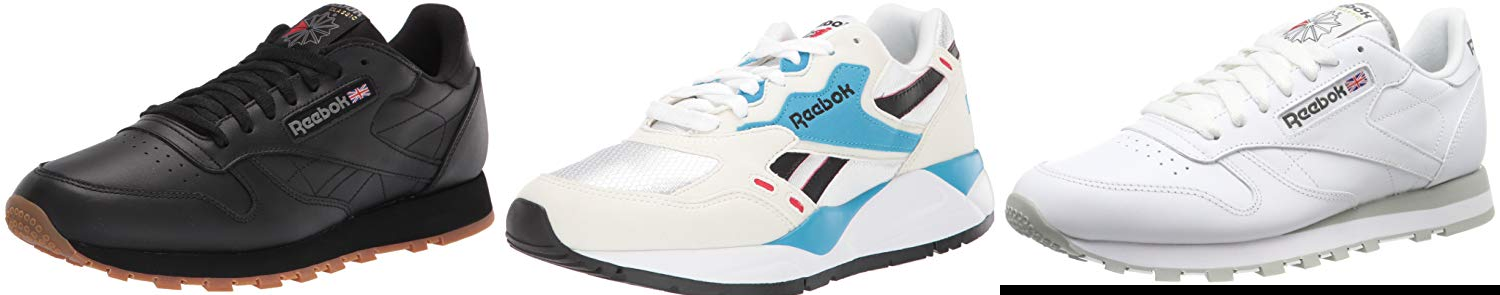

In [24]:
query = "Suggest me some Reebok shoes for men and give me their prices"
result = rag_pipeline.invoke(query)

print(f"Answer: {result['answer']}")
if result["images"]:
  display(image_grid(result["images"], 1, len(result["images"])))

## Using image embeddings
The reason that we used the [Jina AI](https://jina.ai/) CLIP model is that it is a multimodal (text + image) embedding model. A multimodal embedding model can produce embeddings for images and text that are semantically comparable, i.e., an embedding of an image of a cat will be similar to the embedding of the word "cat".

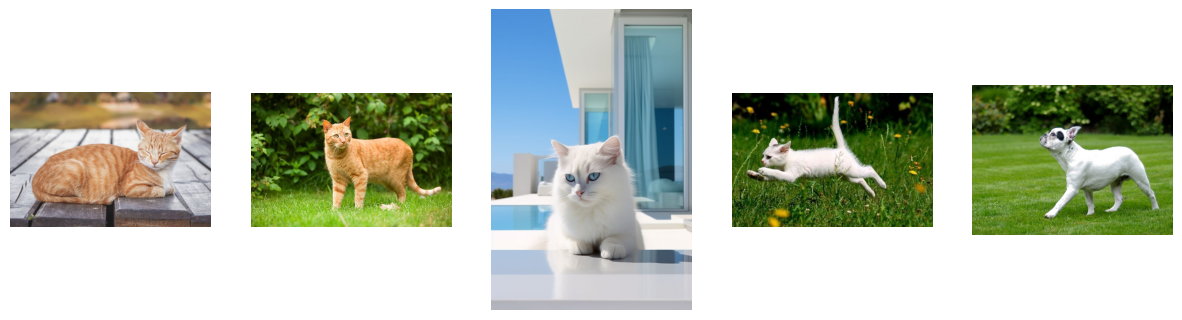

In [25]:
from PIL import Image

# Loading example images
dir_path = f"{PROJECT_ROOT_PATH}/data/example_images/animal_images/"
image_files = os.listdir(dir_path)
images = [Image.open(os.path.join(dir_path, file)) for file in image_files]

# Displaying example images
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for i, image in enumerate(images):
    axs[i].imshow(image)
    axs[i].axis('off')
plt.show()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


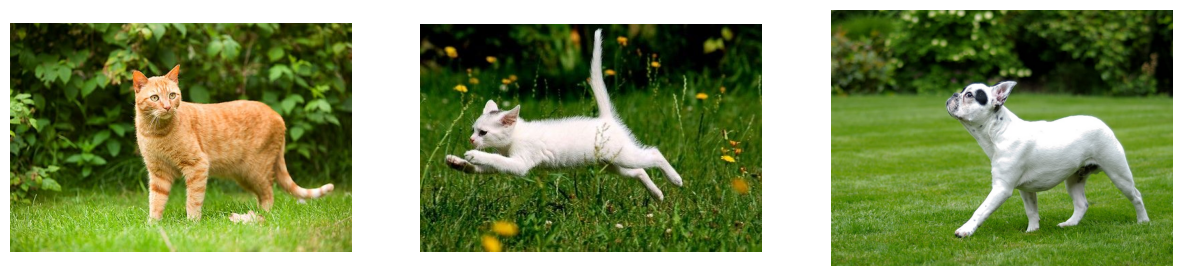

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

query = "An image of a cat in a grass field"

query_embedding = embedding_model.encode_text(query)
image_embeddings = []
similarities = []
for image in images:
    image_embedding = embedding_model.encode_image(image)
    image_embeddings.append(image_embedding)
    similarity = cosine_similarity([query_embedding], [image_embedding])[0][0]
    similarities.append(similarity)

similarities = np.array(similarities)
order_by_similarity = similarities.argsort()[::-1]
ordered_images = [images[i] for i in order_by_similarity][:3]

fig, axs = plt.subplots(1, len(ordered_images), figsize=(15, 5))
for i, image in enumerate(ordered_images):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()

We already computed the embeddings for the images earlier. We load them here:

In [27]:
img_embeddings = {}
path = f"{PROJECT_ROOT_PATH}/data/jinaai_image_embeddings.jsonl"
with open(path, "r") as f:
    for line in f:
        embedding_info = json.loads(line)
        item_id = embedding_info["product_id"]
        embedding = embedding_info["embedding"]
        img_embeddings[item_id] = embedding

We will now create a database using the embeddings of the images:

In [28]:
import chromadb

# Initializing client
chroma_client = chromadb.Client()

# If a collection already exists you must delete it
# chroma_client.delete_collection("img_database")

# Creating collection
img_collection = chroma_client.create_collection(
    name="img_database",
    metadata={"hnsw:space": "cosine"} # The similarity measure used to get query neighbours
    ) # You can define an embedding function here

In [29]:
document_ids = [product_id for product_id in img_embeddings.keys()]
docs_by_id = {doc["id"]: doc for doc in data}
documents = [docs_by_id[doc_id]["text"] for doc_id in document_ids]
metadatas = []

for doc_id in document_ids:
  doc = docs_by_id[doc_id]
  metadata = {key: doc[key] for key in ["url", "closure", "price", "brand", "department"]}
  metadatas.append(metadata)

embeddings = [img_embeddings[doc_id] for doc_id in document_ids]

# Batch Insertion, you cannot index all the data at once
max_batch_size = chroma_client.get_max_batch_size()
for batch_index in range(0, len(embeddings), max_batch_size):
    img_collection.add(
        embeddings=embeddings[batch_index:batch_index + max_batch_size],
        documents=documents[batch_index:batch_index + max_batch_size],
        metadatas=metadatas[batch_index:batch_index + max_batch_size],
        ids=document_ids[batch_index:batch_index + max_batch_size]
    )

Now we can query this database by embedding the user query and searching for similar image embeddings in the database. This only works with multimodal models that can project images and text to the same latent space.

In [30]:
# A dictionary that maps each product ID to its image path
images_dir = f"{PROJECT_ROOT_PATH}/images/images/"
id2image = {
    file_name.split(".")[0]: os.path.join(images_dir, file_name) for file_name in os.listdir(images_dir)
}

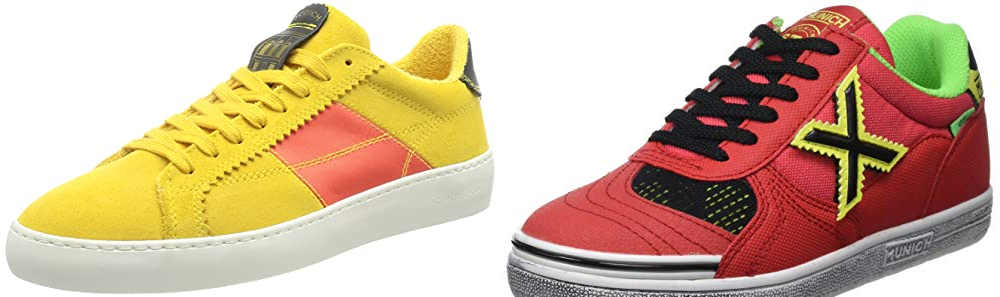

In [31]:
query = "I want a yellow and red sneaker"

query_embedding = embedding_model.encode_text(query)
relevant_docs = img_collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=2 # Number of documents to return
)

product_ids = relevant_docs["ids"][0]
image_paths = [id2image[product_id] for product_id in product_ids]
images = [Image.open(product_image) for product_image in image_paths]

image_grid(images, 1, len(images))

We can also search for products that look like a certain image:

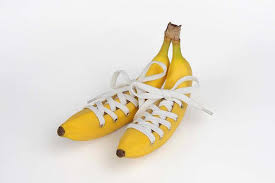

In [32]:
# Searching by image
search_image_path = f"{PROJECT_ROOT_PATH}/data/example_images/shoe_images/banana_shoes.jpeg"
# search_image_path = "/content/data/example_images/shoe_images/clown_shoes.jpg"
search_image = Image.open(search_image_path)
search_image


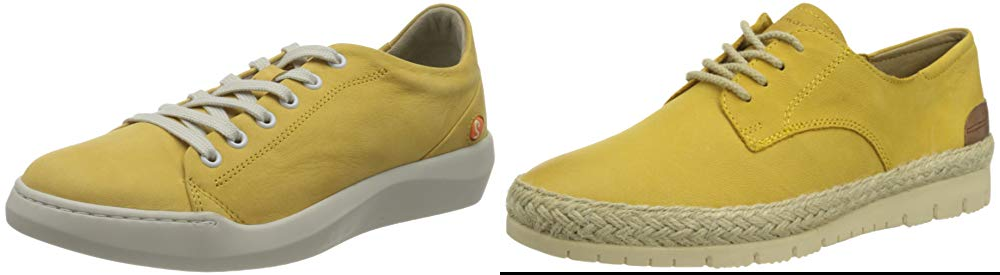

In [33]:
search_image_embedding = embedding_model.encode_image(search_image)
relevant_docs = img_collection.query(
    query_embeddings=[search_image_embedding.tolist()],
    n_results=2 # Number of documents to return
)

product_ids = relevant_docs["ids"][0]

image_paths = [id2image[product_id] for product_id in product_ids]
images = [Image.open(product_image) for product_image in image_paths]

image_grid(images, 1, len(images))

## Improving the RAG system

### Evaluation standard
In order to be able to improve the RAG system, we first need to know how to evaluate its performance. Evaluation of LLMs on downstream tasks is an extremely hard task. The reason is that unlike classification or regrassion, the output is not structured (text) and there is no single true "label". I strongly suggest listening to [this talk](https://www.youtube.com/watch?v=2CIIQ5KZWUM) to learn about challenges in evaluating LLMs on downstream tasks.

### Filtering metadata
We can narrow down our search by filtering based some fields in the metadata, such as search products in a certain price range or from a certain brand. This is a trivial feature in all databases; however, integrating it with a conversational bot is not trivial. One way would be to have an agent, i.e., an LLM, to extract information from the user query and use it to filter the search.

In [34]:
query = "Men sneakers from Reebok"
query_embedding = embedding_model.encode_text(query)
relevant_docs = doc_collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=2, # Number of documents to return
    where={"department": "men"}
)
relevant_docs["metadatas"]

[[{'department': 'men',
   'price': 121.135,
   'brand': 'Reebok',
   'closure': 'lace-up',
   'url': 'https://www.amazon.co.uk/dp/B07H48B2FT'},
  {'price': 109.63,
   'url': 'https://www.amazon.co.uk/dp/B000NI8Z06',
   'department': 'men',
   'brand': 'Reebok',
   'closure': 'lace-up'}]]

### Reranking documents
The vector databases use approximate approaches to ensure fast retrieval. A common approach is to retrieve more documents than required and then rerank them using a better retrieval approach. [Colbertv2](https://arxiv.org/abs/2112.01488) is a good choice for this purpose. It can be easily used through [the RAGatouille library](https://github.com/bclavie/RAGatouille).

### Finetuning
A recent paper [RAFT: Adapting Language Model to Domain Specific RAG](https://arxiv.org/abs/2403.10131) showed improved performance by finetuning an LLM on answering questions given documents. Specifically, they show noticable improvement in performance when using chain-of-thought reasoning when finetuning. Read more about chain-of-thought reasoning [here](https://www.promptingguide.ai/techniques/cot).